## CC5214 Proyecto de Ciencia de Datos - TransApp
# Buses Arrive Time Prediction, a LSTM Time Series Forecast Approach
### C. Jara,  D. Jorquera, G. Dintrans

## Some imports

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

import keras
import keras.backend as K
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

from tqdm.notebook import tqdm
from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from scipy.stats import norm as norm_stat


Using TensorFlow backend.
/home/camilojd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilojd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilojd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilojd/.local/lib/python3.6/site-packages/tensorflo

## Creating Pandas Transapp DataFrames

In [2]:
"""
1. Patente
2. Sonda (servicio interno que identifica recorrido de manera unica) (variantes)
3. Servicio de Usuario (lo que ve el pasajero)
4. Dia y hora (UTC). Ultimo dia de Abril y ultimo día de Mayo
5. Latitud
6. Longitud
7. x (UTM)
8. y (UTM)
9. Distancia en Ruta (desde inicio hasta t)
10. Distancia a la ruta (ortogonal a la polilinea)
11. Velocidad instantanea (maquina del GPS del bus)
12. Operador (codificacion empresa)
13. Identificador de expedición (viaje de un lugar a otro)
"""

def create_gps(gps_name):
    columns = ["Patente", "GPS_COD_SINRUT", "idx_user", "Date", "LAT", "LON", "x_UTM", "y_UTM", "dist_rute", "dist_to_rute", "velocity", "idx_empresa", "idx_expedition"]
    # GPS Data
    df_gps = pd.read_csv(gps_name,header=None,delimiter=";")
    df_gps.columns = columns
    df_gps.index = df_gps["Date"]
    df_gps.index = pd.to_datetime(df_gps.index)
    return df_gps

def create_dict(dict_name):
    # Dictionary Data
    df_dict = pd.read_csv(dict_name,delimiter=";",encoding='latin-1')
    df_dict.index = df_dict["COD_SINRUT"]
    return df_dict

def create_shape(shape_name):
    # Shape Data
    df_shape = pd.read_csv(shape_name,delimiter=";")
    df_shape.index = df_shape["ROUTE_NAME"]
    return df_shape

In [3]:
def extract_bus(bus_name, is_ida, threshold_to_route, df_dict, df_data):
    if is_ida:
        cod_sr = df_dict[(df_dict['COD_USUARI'] == bus_name) & (df_dict['Route_Name'].str.endswith('I'))][['Route_ID', 'Route_Name', 'COD_USUARI']]
    else:
        cod_sr = df_dict[(df_dict['COD_USUARI'] == bus_name) & (df_dict['Route_Name'].str.endswith('R'))][['Route_ID', 'Route_Name', 'COD_USUARI']]
    df = df_data.set_index('GPS_COD_SINRUT').join(cod_sr, how='right').set_index('Date').sort_values(by='Date')
    return df[(df["dist_to_rute"] <= threshold_to_route)]

## Create DataFrames

In [4]:
# Parameters to load data
date = "2019-05-02"
bus_name = '506'
ida = True
threshold_to_route = 100

In [5]:
# Load Data
df_data = create_gps("./data/{}.gps".format(date))
df_dict = create_dict("./data/2019-04-Diccionario_Servicios.csv")
df_shape = create_shape("./data/2019-04-ShapeRutas.csv")

In [6]:
# Select bus
df_gps = extract_bus(bus_name, ida, threshold_to_route, df_dict, df_data) 
df_gps.head()

,Patente,idx_user,LAT,LON,x_UTM,y_UTM,dist_rute,dist_to_rute,velocity,idx_empresa,idx_expedition,Route_ID,Route_Name,COD_USUARI
Date,,,,,,,,,,,,,,
2019-04-30 13:44:18,BJFH24,506I,-33.461333,-70.620042,349447,6296394,23274,0,28,5,69,8945,506I,506
2019-04-30 13:44:48,BJFH24,506I,-33.461441,-70.618667,349575,6296384,23402,0,0,5,69,8945,506I,506
2019-05-01 23:58:01,BJFC56,506I,-33.465099,-70.591803,352078,6296017,25971,0,39,5,75,8945,506I,506
2019-05-01 23:58:02,BJFH61,506I,-33.539016,-70.783379,334414,6287531,594,1,28,5,70,8945,506I,506
2019-05-01 23:58:05,FLXD43,506I,-33.516736,-70.757310,336793,6290043,5578,6,0,5,65,8945,506I,506


# Algorithm

## First step: Sample points

In [7]:
columns_filter = ["Patente","x_UTM","y_UTM","velocity","dist_rute"]
bus_idx = df_gps['idx_user'].unique()[0]

In [8]:
# Number of samples
frac_samples = 0.4 #0.4

sample_points = df_shape.loc[bus_idx].sample(frac=frac_samples)[["X-Coordinate", "Y-Coordinate"]].reset_index().drop('ROUTE_NAME',axis=1)
print('Number of samples:', sample_points.shape[0])
sample_points.head()

Number of samples: 302


,X-Coordinate,Y-Coordinate
0,336785,6290889
1,355982,6295026
2,356835,6294837
3,336756,6291973
4,349403,6296393


## Second step: Search buses in sample points

In [9]:
def search_buses_points(sample_points):
    # Search buses which goes through sample points
    buses_sample_points = []
    for i, sample in sample_points.iterrows():
        epsilon = 0.1
        df_epsilon = df_gps[(df_gps["x_UTM"] - sample[0] <= epsilon) & (df_gps["y_UTM"] - sample[1] <= epsilon)]
        if(df_epsilon.empty):
            sample_points.drop(i, inplace=True)
            continue
        buses_sample_points.append(df_epsilon)
    print('Buses in sample points:', len(buses_sample_points))
    print('Number of samples left:', sample_points.shape[0])
    buses_patentes_points = [buses_point.set_index(['Patente', buses_point.index]).sort_index() for buses_point in buses_sample_points]
    return buses_patentes_points

In [10]:
buses_patentes_points = search_buses_points(sample_points)

Buses in sample points: 302
Number of samples left: 302


In [11]:
print(len(buses_patentes_points))
buses_patentes_points[0].head()

302


idx_user        LAT        LON   x_UTM    y_UTM  \
Patente Date                                                                  
BDXR17  2019-05-02 16:21:22     506I -33.542206 -70.787925  333998  6287170   
        2019-05-02 16:21:52     506I -33.541729 -70.787247  334060  6287224   
        2019-05-02 16:22:22     506I -33.540748 -70.785827  334190  6287335   
        2019-05-02 16:22:52     506I -33.540695 -70.785761  334196  6287341   
        2019-05-02 16:23:22     506I -33.539397 -70.783882  334368  6287488   

                             dist_rute  dist_to_rute  velocity  idx_empresa  \
Patente Date                                                                  
BDXR17  2019-05-02 16:21:22         44             2        28            5   
        2019-05-02 16:21:52        126             1         5            5   
        2019-05-02 16:22:22        297             1        14            5   
        2019-05-02 16:22:52        305             0         6            5   
        2019-05-02 16:23:22        532             0        26            5   

                             idx_expedition  Route_ID Route_Name COD_USUARI  
Patente Date                                                                 
BDXR17  2019-05-02 16:21:22             253      8945       506I        506  
        2019-05-02 16:21:52             253      8945       506I        506  
        2019-05-02 16:22:22             253      8945       506I        506  
        2019-05-02 16:22:52             253      8945       506I        506  
        2019-05-02 16:23:22             253      8945       506I        506

## Third step: Create dist_point and target_time

In [12]:
def create_dist_target(sample_points,buses_patentes_points,n_min_travel):
    buses_expeditions = []
    point_coords = []
    # For every point and buses that arrive to point 
    for point, buses_point in tqdm(zip(sample_points.values, buses_patentes_points),total=len(sample_points)):
        # For every expedition
        for idx_exp in buses_point['idx_expedition'].unique():
            patentes_expedition = buses_point[buses_point['idx_expedition'] == idx_exp].index.get_level_values(0).unique()
            # For every patent
            for patente in patentes_expedition:
                bus_point = buses_point[(buses_point['idx_expedition'] == idx_exp) & (buses_point.index.get_level_values(0) == patente)]
                bus_point.loc[:, "dist_point"] = np.linalg.norm(bus_point[["x_UTM","y_UTM"]].values - point, axis=1)
                end_time_expedition = bus_point['dist_point'].idxmin()[1]
                expedition = df_gps.loc[(df_gps['idx_expedition'] == idx_exp) & (df_gps['Patente'] == patente)]
                expedition_end = expedition.loc[expedition.index.get_level_values(0) <= end_time_expedition]
                # Check if n_min
                if expedition_end.shape[0] <= n_min_travel:
                    continue
                # Distance Polyline
                expedition_end.loc[:, "dist_target"] = abs(expedition_end['dist_rute'].iloc[-1] - expedition_end['dist_rute'])

                # Correct sample time
                expedition_end.index = pd.to_datetime(expedition_end.index.to_series()).dt.round('30s')

                # Create hour column
                expedition_end.loc[:, 'hour'] = expedition_end.index.hour

                # Imputation on sample time
                min_timestamp = expedition_end.index.min()
                max_timestamp = expedition_end.index.max()
                timestamp = pd.date_range(start=min_timestamp, end=max_timestamp, freq='30s').to_frame(name='Timestamp')
                expedition_join = expedition_end.join(timestamp, how='outer')
                expedition_join.set_index(['Timestamp'], inplace=True)
                expedition_join.fillna(method='ffill', inplace=True)

                # Create target time in minutes
                target = [((pd.to_datetime(expedition_join.index[-1]) - pd.to_datetime(start_time)).seconds//60)%60 for start_time in expedition_join.index]
                expedition_join.loc[:,"target_time"] = target

                if (not expedition_join['target_time'].is_monotonic_decreasing) or (not expedition_join['dist_target'].is_monotonic_decreasing):
                    continue

                if (len(expedition_join)==0):
                    continue

                buses_expeditions.append(expedition_join)
                point_coords.append(expedition_join[["LON", "LAT"]].iloc[-1].to_frame().T)
    point_coords = pd.concat(point_coords)
    return buses_expeditions, point_coords

In [13]:
# Select number of min counts for every travel
n_min_travel = 80 #90

buses_expeditions, point_coords = create_dist_target(sample_points,buses_patentes_points,n_min_travel)

print('Quantity of buses which passes though samples:', len(buses_expeditions))

/home/camilojd/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/camilojd/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



Quantity of buses which passes though samples: 13103


In [14]:
def plot_route(coords, bus_name):
    # Defining Map and geometry points
    street_map = gpd.read_file('./Comunas_RM_Mapas_Vectoriales_Santiago/Comuna.shp')
    crs = {'init' : 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(coords["LON"],coords["LAT"])]
    
    # Creating GeoDataFrame
    gdf = gpd.GeoDataFrame(coords, crs=crs, geometry=geometry)

    # Plotting
    fig, ax = plt.subplots(figsize=(15,15))
    street_map.plot(ax=ax, cmap="Blues") #color="white", edgecolor="black")
    gdf.plot(ax=ax, markersize=15, cmap="Reds", marker="o", label=bus_name)
    plt.legend(prop={'size':15})

    minx, miny, maxx, maxy = gdf.total_bounds
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)

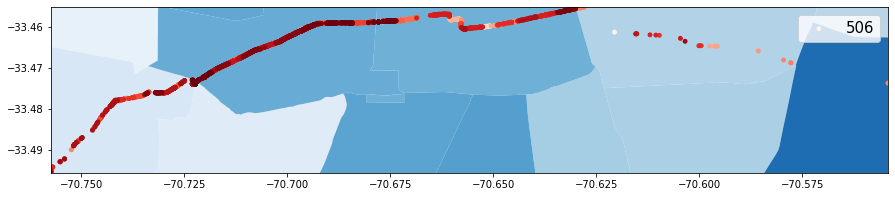

In [15]:
# Sample points in route
plot_route(point_coords, bus_name)

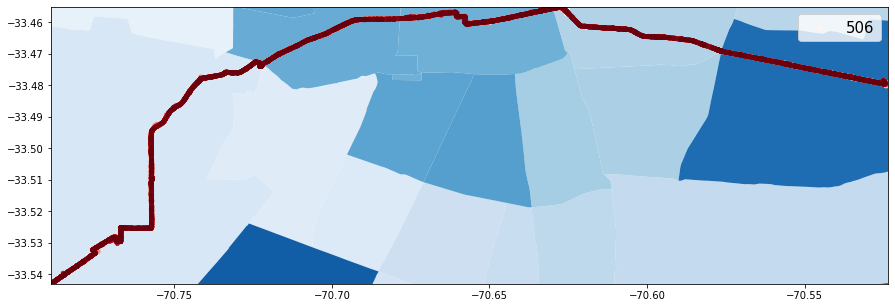

In [16]:
# Real route
plot_route(df_gps, bus_name)

# Retrieve and split data for model

In [17]:
# Select Data
columns = ["hour","x_UTM","y_UTM","dist_rute", "velocity","dist_target","target_time"]

# Percent of split
train_percent = 0.4 
val_percent = 0.5

# Shuffling data indexes
data_sample_idx = np.arange(0,len(buses_expeditions))
np.random.shuffle(data_sample_idx)

# Train idx in data
first_train = int(len(buses_expeditions) * train_percent)
first_val = int((len(buses_expeditions) - first_train) * val_percent)

# Index
i_train = data_sample_idx[:first_train]
i_val = data_sample_idx[first_train:first_train+first_val]
i_test = data_sample_idx[first_train+first_val:]

X_fitter = []

for i in range(len(buses_expeditions)):
    if i in i_train:
        X_fitter.append(buses_expeditions[i][columns[:-1]].values)
X_fitter = np.concatenate(X_fitter)

# Scale data
scaler_x = MinMaxScaler()
scaler_x = scaler_x.fit(X_fitter)

In [18]:
def create_timeseries(buses_expeditions, columns, batch_size, seq_length):
    data_index = []
    X_gens, y_gens = [], []

    for i, bus_expedition in tqdm(enumerate(buses_expeditions), total=len(buses_expeditions)):
        df_data_bus = bus_expedition[columns]

        # Separate data in features and targets
        X = df_data_bus[columns[:-1]]
        y = df_data_bus[columns[-1]]

        # Store indexes
        data_index.append(y.index)

        # Scale data
        X = scaler_x.transform(X)

        # Time Sequences
        data_gen = TimeseriesGenerator(X, y.squeeze(), length=seq_length, batch_size=batch_size)

        # Unpack Time series to numpy arrays
        X_gen, y_gen = data_gen[0]

        # Storing data
        X_gens.append(X_gen)
        y_gens.append(y_gen)

    data_index = np.array(data_index)
    X_gens = np.array(X_gens)
    y_gens = np.array(y_gens)
    return X_gens, y_gens, data_index

In [19]:
# Parameters to create time series
batch_size = 128 #500000
seq_length = 7

X_gens, y_gens, data_index = create_timeseries(buses_expeditions, columns, batch_size, seq_length)

In [20]:
# Split Train and Test
X_train, y_train = X_gens[i_train], y_gens[i_train]
X_val, y_val = X_gens[i_val], y_gens[i_val]
X_test, y_test = X_gens[i_test], y_gens[i_test]

# Store indexes
train_index = data_index[i_train]
val_index = data_index[i_val]
test_index = data_index[i_test]

print("First batch shape:")
print("X_train:", X_train[0].shape)
print("y_train:", y_train[0].shape)
print("X_val:", X_val[0].shape)
print("y_val:", y_val[0].shape)
print("X_test:", X_test[0].shape)
print("y_test:", y_test[0].shape)

First batch shape:
X_train: (93, 7, 6)
y_train: (93,)
X_val: (112, 7, 6)
y_val: (112,)
X_test: (98, 7, 6)
y_test: (98,)


## Create model

In [21]:
# Parameters for learning
input_units = 10
learning_rate = 0.00001
epochs = 100
patience = 5

In [22]:
# Model
lstm = Sequential()
lstm.add(LSTM(input_units, return_sequences=False, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
                input_shape=(X_train[0].shape[1], X_train[0].shape[2])))
lstm.add(Dropout(0.2))
lstm.add(Dense(20, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))

# Compilation
optim = optimizers.Adam(lr=learning_rate)
lstm.compile(loss='mse', optimizer=optim)

# Train
earlies = np.ones(patience) * 1e10
stop = patience
t_train = time.clock()
train_loss, val_loss = [], []
for epoch in range(epochs):
    t = time.clock()
    t_losses, v_losses = [], []
    print('Epoch {}/{}:'.format(epoch,epochs))
    for i in range(len(X_train)):
        t_loss = lstm.train_on_batch(X_train[i], y_train[i])
        t_losses.append(t_loss)
        if i < len(X_val):
            v_loss = lstm.test_on_batch(X_val[i], y_val[i])
            v_losses.append(v_loss)
    avg_loss_train = np.array(t_losses).mean()
    avg_loss_val = np.array(v_losses).mean()
    train_loss.append(avg_loss_train)
    val_loss.append(avg_loss_val)
    print('{:.2f}s | loss: {:.3f}, val_loss: {:.3f} '.format((time.clock() - t), avg_loss_train, avg_loss_val))
    
    # Early Stopping
    earlies[epoch % patience] = avg_loss_val
    if earlies.min() != avg_loss_val:
        stop -= 1
        if stop == 0:
            print('=== Early stopping ===')
            break
    else:
        stop = patience  
    
print("Training Finished! Elapsed Time: {:.2f} minutes".format((time.clock() - t_train) / 60))

Epoch 0/100:


W1226 03:16:40.813191 140635645560640 deprecation_wrapper.py:119] From /home/camilojd/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



47.91s | loss: 632.351, val_loss: 634.986 
Epoch 1/100:
47.16s | loss: 504.521, val_loss: 539.061 
Epoch 2/100:
47.16s | loss: 316.353, val_loss: 293.496 
Epoch 3/100:
47.26s | loss: 216.226, val_loss: 162.297 
Epoch 4/100:
47.24s | loss: 163.944, val_loss: 95.636 
Epoch 5/100:
47.03s | loss: 138.689, val_loss: 68.576 
Epoch 6/100:
46.78s | loss: 123.485, val_loss: 55.936 
Epoch 7/100:
47.63s | loss: 113.608, val_loss: 48.724 
Epoch 8/100:
47.96s | loss: 106.267, val_loss: 44.035 
Epoch 9/100:
46.77s | loss: 100.648, val_loss: 40.865 
Epoch 10/100:
48.89s | loss: 96.292, val_loss: 38.242 
Epoch 11/100:
48.20s | loss: 92.801, val_loss: 36.688 
Epoch 12/100:
47.08s | loss: 89.864, val_loss: 34.929 
Epoch 13/100:
47.53s | loss: 87.293, val_loss: 33.513 
Epoch 14/100:
47.01s | loss: 84.663, val_loss: 32.320 
Epoch 15/100:
47.60s | loss: 83.370, val_loss: 31.918 
Epoch 16/100:
46.75s | loss: 81.725, val_loss: 31.209 
Epoch 17/100:
47.74s | loss: 80.486, val_loss: 30.771 
Epoch 18/100:
46.80

<Figure size 432x288 with 0 Axes>

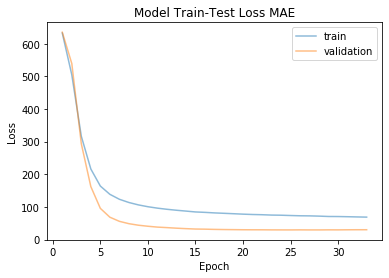

In [23]:
# Train and val Loss
loss_fig = plt.figure()
loss_title = 'Model Train-Test Loss MAE' #MSE

loss_fig = plt.figure()
plt.plot(np.arange(1, len(train_loss) + 1), train_loss,label="train",alpha=0.5)
plt.plot(np.arange(1, len(val_loss) + 1), val_loss,label="validation",alpha=0.5)
plt.title(loss_title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
# LSTM Prediction and Padding sequence
thresholds = [50,40,30,20,10,5]

y_pred_thresholds = []
y_real_thresholds = []
for thresh in tqdm(thresholds, total=len(thresholds)):
    y_preds = []
    y_reals = []
    for i in range(len(X_test)):
        lstm_pred = lstm.predict_on_batch(X_test[i]).squeeze()

        y_pred_pad = np.pad(lstm_pred, (seq_length,0), 'constant', constant_values=0)
        y_real_pad = np.pad(y_test[i], (seq_length,0), 'constant', constant_values=0)

        if (y_pred_pad.shape != test_index[i].shape):
            continue        

        df_y_pred = pd.DataFrame(y_pred_pad,index=test_index[i], columns=['pred']) 
        df_y_real = pd.DataFrame(y_real_pad,index=test_index[i], columns=['pred'])
        
        df_y_pred[df_y_pred >= thresh] = thresh
        df_y_real[df_y_real >= thresh] = thresh

        y_preds.append(df_y_pred)
        y_reals.append(df_y_real)

    y_pred = pd.concat(y_preds)
    y_real = pd.concat(y_reals)
    y_pred_thresholds.append(y_pred)
    y_real_thresholds.append(y_real)

## Evaluate model

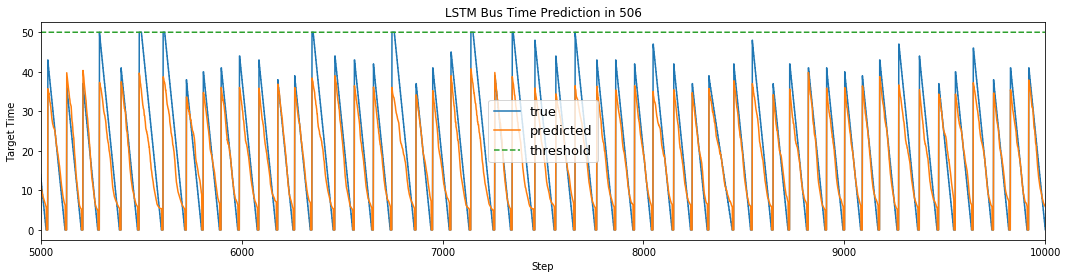

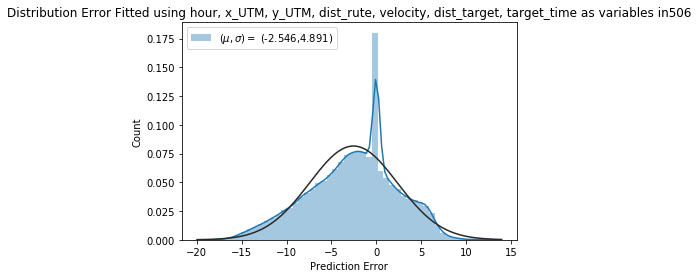

Error Distribution Norm Fitted parameters (mu,sigma): (-2.545996970967126, 4.89075531999072)
MSE: 30.401588176191293


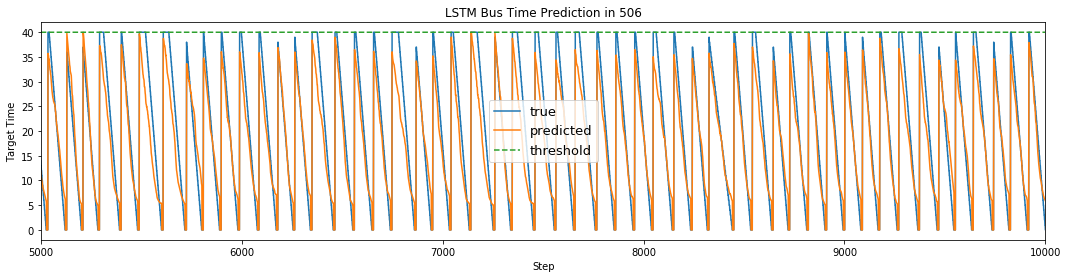

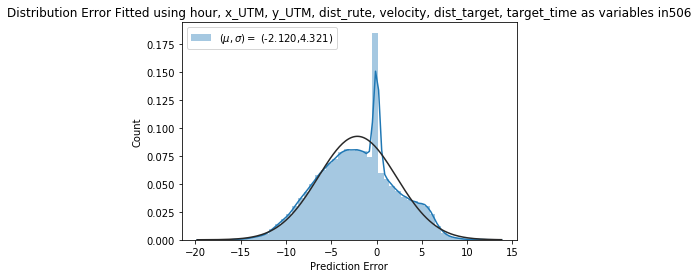

Error Distribution Norm Fitted parameters (mu,sigma): (-2.1195791656453036, 4.3212473993163965)
MSE: 23.16579492553636


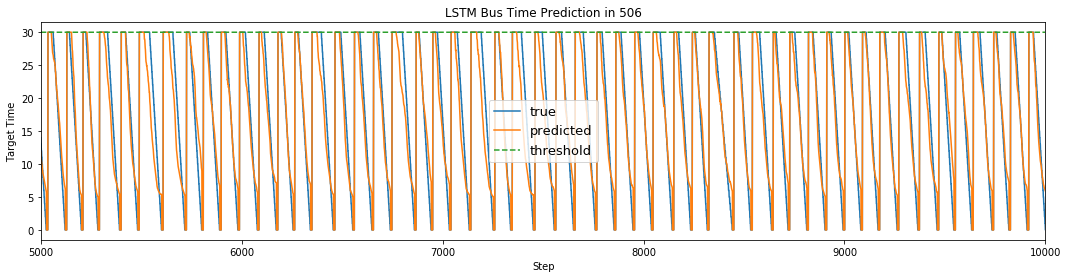

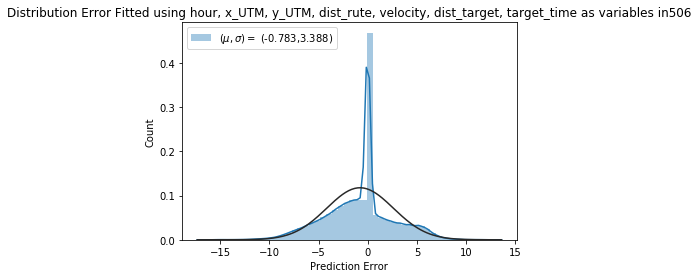

Error Distribution Norm Fitted parameters (mu,sigma): (-0.7834693168484902, 3.3877172068495676)
MSE: 12.090452044027675


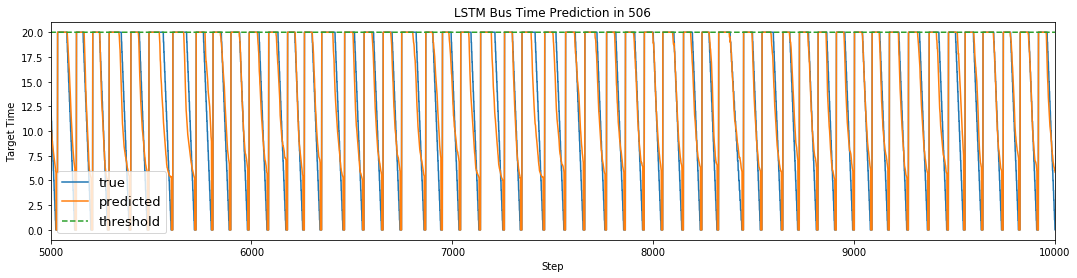

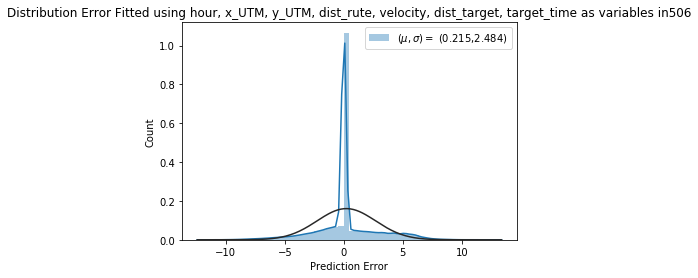

Error Distribution Norm Fitted parameters (mu,sigma): (0.21460941592274704, 2.484132304445895)
MSE: 6.216970507394374


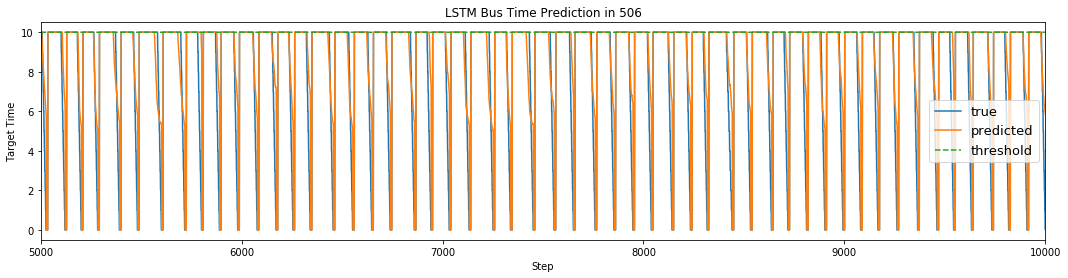

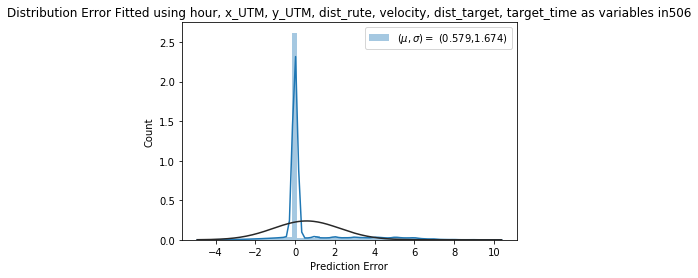

Error Distribution Norm Fitted parameters (mu,sigma): (0.578965358722904, 1.6741599668048173)
MSE: 3.1380124810530465


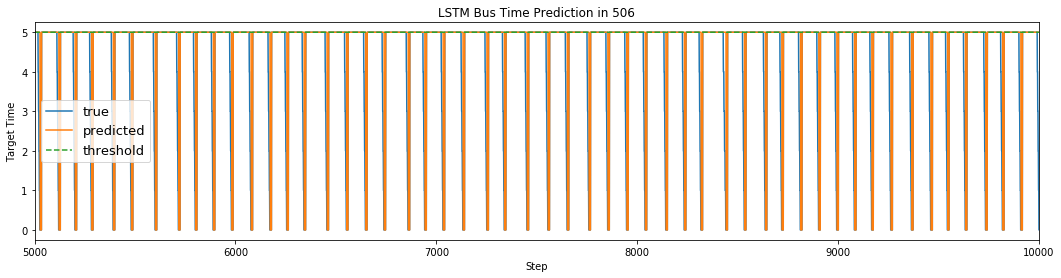

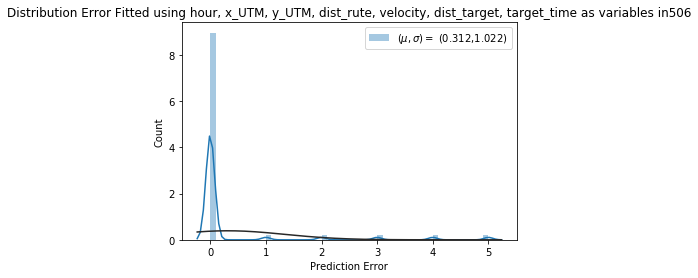

Error Distribution Norm Fitted parameters (mu,sigma): (0.3115199218768995, 1.0221462800710384)
MSE: 1.1418276795892512


In [25]:
import seaborn as sns

x_lim1 = 5000
x_lim2 = 10000
for i in range(len(thresholds)):
    y_pred = y_pred_thresholds[i]
    y_real = y_real_thresholds[i]
    
    # Plot LSTM Prediction
    plt.figure(figsize=(18,4))
    plt.plot(y_real.values, label='true')
    plt.plot(y_pred.values, label='predicted')
    plt.plot(range(0, y_real.shape[0]), np.ones(y_real.shape[0]) * thresholds[i], '--', label='threshold')
    plt.legend(loc='best', prop={'size': 13})
    plt.title('LSTM Bus Time Prediction in ' + bus_name)
    plt.ylabel('Target Time')
    plt.xlabel('Step')
    plt.xlim(x_lim1, x_lim2)
    #plt.savefig('f1.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Metrics
    MSE = mean_squared_error(y_pred.values, y_real.values)
    error = y_pred.values - y_real.values
    norm_fitted = norm_stat.fit(error)

    # Distribution Error Histogram
    hist_fig, ax = plt.subplots()
    ax = sns.distplot(error,fit=norm_stat,label= r"$(\mu,\sigma)=$ (" + str('%.3f'%norm_fitted[0]) + "," + str('%.3f'%norm_fitted[1]) + ")"  )
    hist_title = 'Distribution Error Fitted using ' + ', '.join(columns) + ' as variables in ' + bus_name
    plt.title(hist_title)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.legend()
    #hist_fig.savefig("./results/MLP/"+hist_title+" norm="+str(norm)+".png", bbox_inches='tight')
    plt.show()


    print("Error Distribution Norm Fitted parameters (mu,sigma):", norm_stat.fit(error))
    print("MSE:", MSE)


## Test in another day

In [26]:
date = "2019-05-07"

In [27]:
df_data = create_gps("./data/{}.gps".format(date))

In [28]:
# Select bus
df_gps = extract_bus(bus_name, ida, threshold_to_route, df_dict, df_data) 
df_gps.head()

,Patente,idx_user,LAT,LON,x_UTM,y_UTM,dist_rute,dist_to_rute,velocity,idx_empresa,idx_expedition,Route_ID,Route_Name,COD_USUARI
Date,,,,,,,,,,,,,,
2019-05-06 23:36:39,BJFH46,506I,-33.459916,-70.651562,346515,6296505,19975,4,29,5,81,8945,506I,506
2019-05-06 23:36:42,BJFB28,506I,-33.473214,-70.722728,339925,6294923,12379,1,0,5,102,8945,506I,506
2019-05-06 23:36:42,FLXG41,506I,-33.478937,-70.524795,358328,6294576,32448,67,0,5,126,8945,506I,506
2019-05-06 23:37:20,BJFH29,506I,-33.477184,-70.737399,338569,6294460,10816,4,45,5,82,8945,506I,506
2019-05-06 23:37:22,BJFH43,506I,-33.457629,-70.664117,345344,6296740,18435,52,0,5,98,8945,506I,506


In [29]:
bus_idx = df_gps['idx_user'].unique()[0]
sample_points = df_shape.loc[bus_idx].sample(frac=frac_samples)[["X-Coordinate", "Y-Coordinate"]].reset_index().drop('ROUTE_NAME',axis=1)
print('Number of samples:', sample_points.shape[0])
sample_points.head()

Number of samples: 302


,X-Coordinate,Y-Coordinate
0,336831,6289052
1,337108,6292839
2,343138,6296548
3,338779,6294513
4,341520,6295871


In [30]:
buses_patentes_points = search_buses_points(sample_points)

Buses in sample points: 302
Number of samples left: 302


In [31]:
buses_expeditions, point_coords = create_dist_target(sample_points,buses_patentes_points,n_min_travel)

print('Quantity of buses which passes though samples:', len(buses_expeditions))

/home/camilojd/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/camilojd/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



Quantity of buses which passes though samples: 11323


In [32]:
# Shuffling data indexes
data_sample_idx = np.arange(0,len(buses_expeditions))
np.random.shuffle(data_sample_idx)

# Train idx in data
first_train = int(len(buses_expeditions) * train_percent)
first_val = int((len(buses_expeditions) - first_train) * val_percent)

# Index
i_train = data_sample_idx[:first_train]
i_val = data_sample_idx[first_train:first_train+first_val]
i_test = data_sample_idx[first_train+first_val:]

In [33]:
X_gens, y_gens, data_index = create_timeseries(buses_expeditions, columns, batch_size, seq_length)

In [34]:
# Split Train and Test
X_train, y_train = X_gens[i_train], y_gens[i_train]
X_val, y_val = X_gens[i_val], y_gens[i_val]
X_test, y_test = X_gens[i_test], y_gens[i_test]

# Store indexes
train_index = data_index[i_train]
val_index = data_index[i_val]
test_index = data_index[i_test]

print("First batch shape:")
print("X_train:", X_train[0].shape)
print("y_train:", y_train[0].shape)
print("X_val:", X_val[0].shape)
print("y_val:", y_val[0].shape)
print("X_test:", X_test[0].shape)
print("y_test:", y_test[0].shape)

First batch shape:
X_train: (100, 7, 6)
y_train: (100,)
X_val: (84, 7, 6)
y_val: (84,)
X_test: (86, 7, 6)
y_test: (86,)


In [44]:
# LSTM Prediction and Padding sequence
y_pred_thresholds = []
y_real_thresholds = []
for thresh in tqdm(thresholds, total=len(thresholds)):
    y_preds = []
    y_reals = []
    for i in range(len(X_test)):
        lstm_pred = lstm.predict_on_batch(X_test[i]).squeeze()

        y_pred_pad = np.pad(lstm_pred, (seq_length,0), 'constant', constant_values=0)
        y_real_pad = np.pad(y_test[i], (seq_length,0), 'constant', constant_values=0)

        if (y_pred_pad.shape != test_index[i].shape):
            continue        

        df_y_pred = pd.DataFrame(y_pred_pad,index=test_index[i], columns=['pred']) 
        df_y_real = pd.DataFrame(y_real_pad,index=test_index[i], columns=['pred'])
        
        df_y_pred[df_y_pred >= thresh] = thresh
        df_y_real[df_y_real >= thresh] = thresh

        y_preds.append(df_y_pred)
        y_reals.append(df_y_real)

    y_pred = pd.concat(y_preds)
    y_real = pd.concat(y_reals)
    y_pred_thresholds.append(y_pred)
    y_real_thresholds.append(y_real)

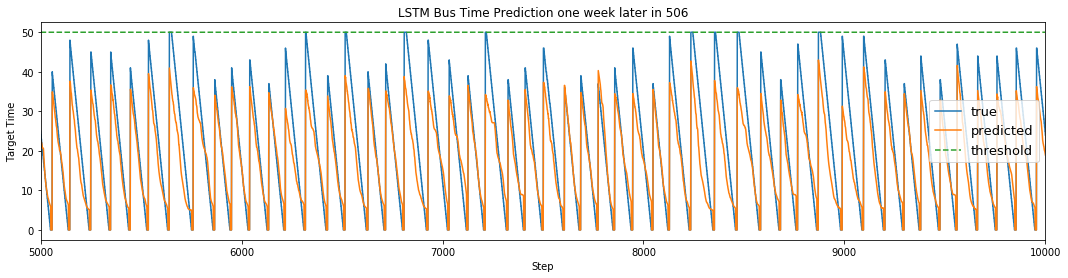

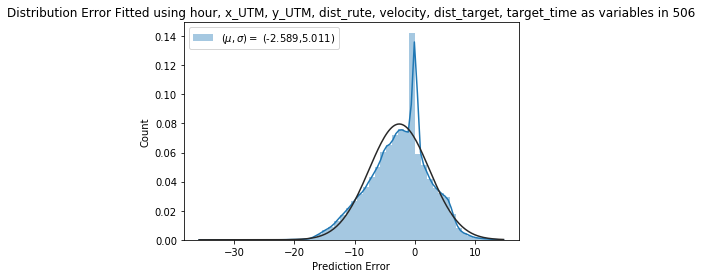

Error Distribution Norm Fitted parameters (mu,sigma): (-2.5885071177580596, 5.010870965099397)
MSE: 31.809196927560297


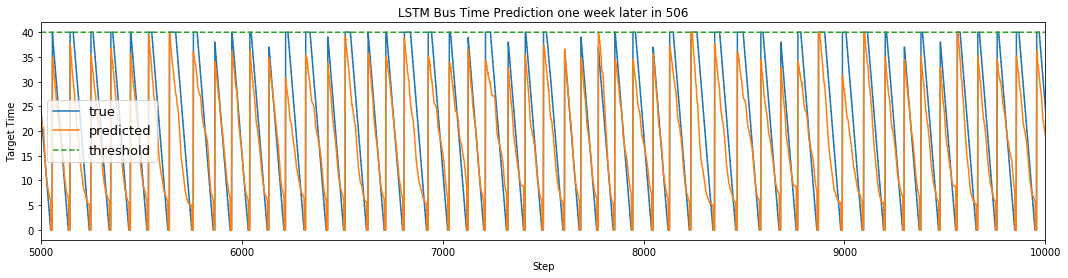

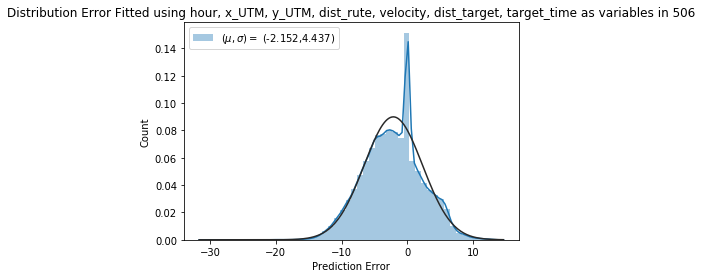

Error Distribution Norm Fitted parameters (mu,sigma): (-2.151969621023107, 4.43666818168553)
MSE: 24.31499780418713


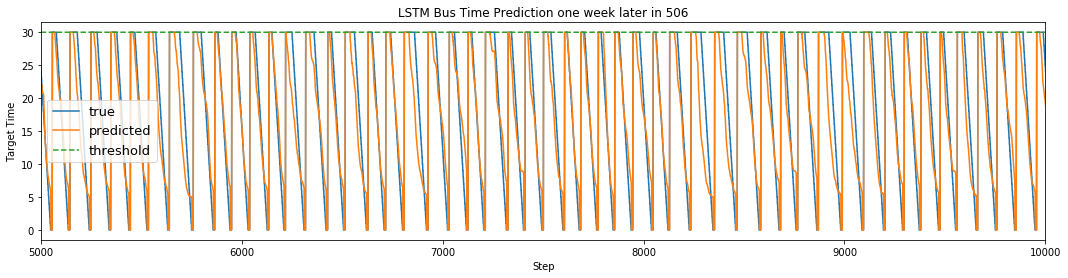

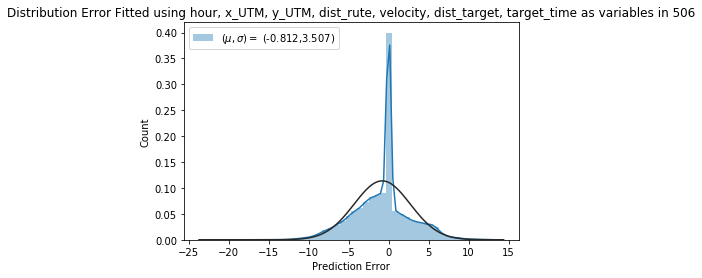

Error Distribution Norm Fitted parameters (mu,sigma): (-0.8117763836034564, 3.5073981331306006)
MSE: 12.960822561264333


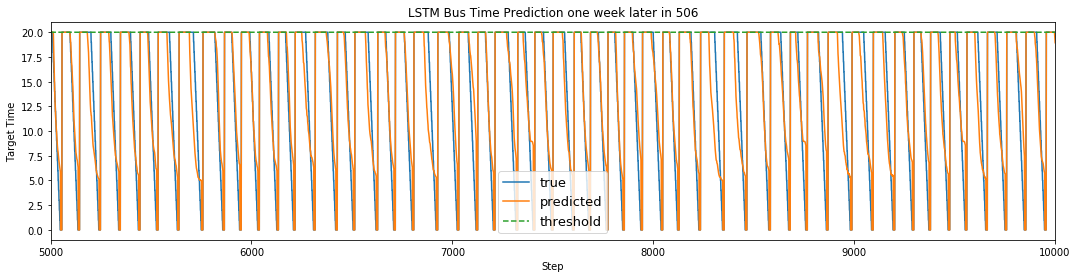

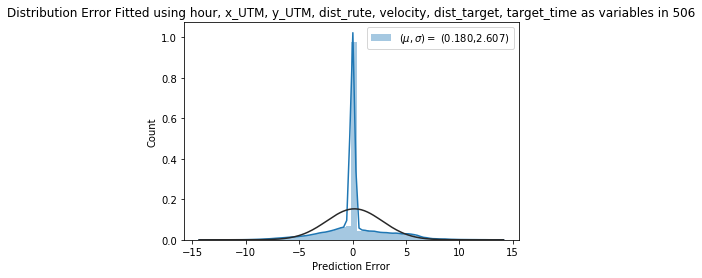

Error Distribution Norm Fitted parameters (mu,sigma): (0.17984280135269307, 2.607000585115313)
MSE: 6.828795483989972


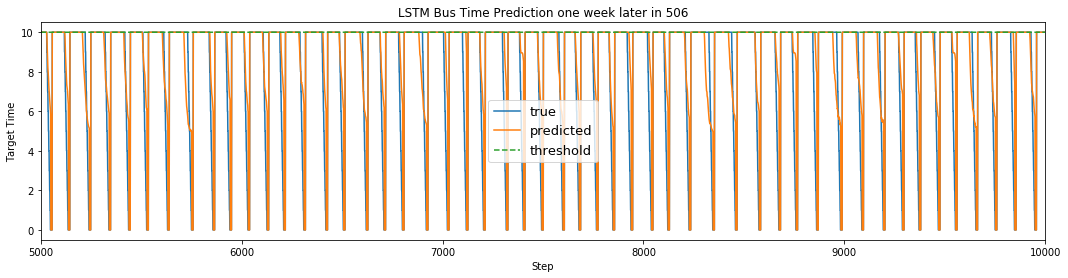

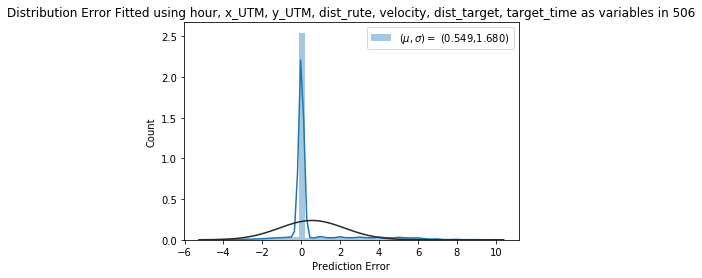

Error Distribution Norm Fitted parameters (mu,sigma): (0.5491615319112545, 1.6803633720991773)
MSE: 3.1251994504236325


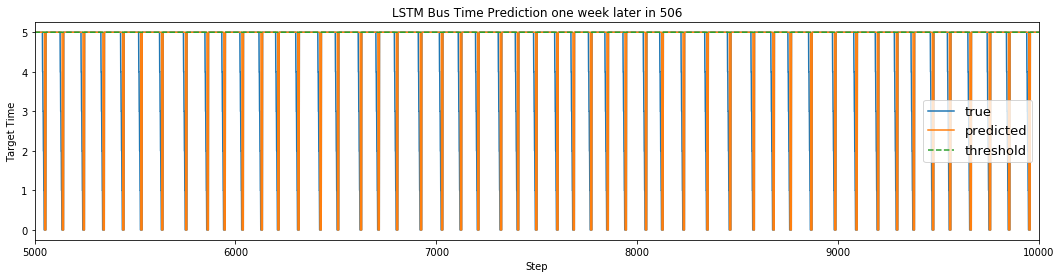

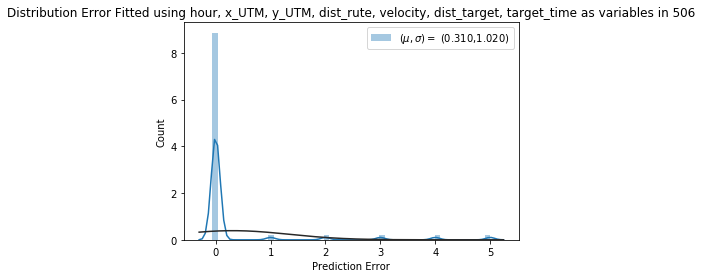

Error Distribution Norm Fitted parameters (mu,sigma): (0.31014729414499975, 1.020276690721015)
MSE: 1.1371558696940902


In [45]:
x_lim1 = 5000
x_lim2 = 10000
for i in range(len(thresholds)):
    y_pred = y_pred_thresholds[i]
    y_real = y_real_thresholds[i]
    
    # Plot LSTM Prediction
    plt.figure(figsize=(18,4))
    plt.plot(y_real.values, label='true')
    plt.plot(y_pred.values, label='predicted')
    plt.plot(range(0, y_real.shape[0]), np.ones(y_real.shape[0]) * thresholds[i], '--', label='threshold')
    plt.legend(loc='best', prop={'size': 13})
    plt.title('LSTM Bus Time Prediction one week later in ' + bus_name)
    plt.ylabel('Target Time')
    plt.xlabel('Step')
    plt.xlim(x_lim1, x_lim2)
    #plt.savefig('f1.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Metrics
    MSE = mean_squared_error(y_pred.values, y_real.values)
    error = y_pred.values - y_real.values
    norm_fitted = norm_stat.fit(error)

    # Distribution Error Histogram
    hist_fig, ax = plt.subplots()
    ax = sns.distplot(error,fit=norm_stat,label= r"$(\mu,\sigma)=$ (" + str('%.3f'%norm_fitted[0]) + "," + str('%.3f'%norm_fitted[1]) + ")"  )
    hist_title = 'Distribution Error Fitted using ' + ', '.join(columns) + ' as variables in ' + bus_name
    plt.title(hist_title)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.legend()
    #hist_fig.savefig("./results/MLP/"+hist_title+" norm="+str(norm)+".png", bbox_inches='tight')
    plt.show()


    print("Error Distribution Norm Fitted parameters (mu,sigma):", norm_stat.fit(error))
    print("MSE:", MSE)
